In [12]:
# -- driver_run_forecast_LV1.py  --
# master python script to do a full LV1 forecast simulation

import sys
#import pickle
#import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timezone
import gc
import resource
#import xarray as xr
#import netCDF4 as nc
import importlib

##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import util_functions as utlfuns 
import plotting_functions as pltfuns
from util_functions import s_coordinate_4
from get_PFM_info import get_PFM_info
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1


PFM=get_PFM_info()

run_type = 'forecast'
# we will use hycom for IC and BC
ocn_mod = PFM['ocn_model']
print('ocean boundary and initial conditions will be from:')
print(ocn_mod)
# we will use nam_nest for the atm forcing
atm_mod = PFM['atm_model']
print('atm forcing will be from:')
print(atm_mod)
# we will use opendap, and netcdf to grab ocn, and atm data
get_method = 'open_dap_nc'
# figure out what the time is local and UTC
start_time = datetime.now()
utc_time = datetime.now(timezone.utc)
year_utc = utc_time.year
month_utc = utc_time.month
day_utc = utc_time.day
hour_utc = utc_time.hour

print("Starting: driver_run_forecast_LV1: Current local Time =", start_time, "UTC = ",utc_time)

if hour_utc < 12:
    hour_utc=12
    day_utc=day_utc-1  # this only works if day_utc \neq 1

yyyymmdd = "%d%02d%02d" % (year_utc, month_utc, day_utc)
    
#yyyymmdd = '20240717'
# the hour in Z of the forecast, hycom has forecasts once per day starting at 1200Z
hhmm='1200'
forecastZdatestr = yyyymmdd+hhmm+'Z'   # this could be used for model output to indicate when model was initialized.

yyyymmdd = '20240730'
print("Preparing forecast starting on ",yyyymmdd)


# get the ROMS grid as a dict
RMG = grdfuns.roms_grid_to_dict(PFM['lv1_grid_file'])

get_PFM_info(): running onswell
ocean boundary and initial conditions will be from:
hycom
atm forcing will be from:
nam_nest
Starting: driver_run_forecast_LV1: Current local Time = 2024-08-05 14:49:30.559812 UTC =  2024-08-05 21:49:30.559830+00:00
Preparing forecast starting on  20240730


In [13]:
# Loading ATM
ATM = atmfuns.get_atm_data_as_dict(yyyymmdd,hhmm,run_type,atm_mod,get_method,PFM)

getting atm forecast for:
[datetime.datetime(2024, 7, 30, 12, 0)
 datetime.datetime(2024, 7, 30, 15, 0)
 datetime.datetime(2024, 7, 30, 18, 0)
 datetime.datetime(2024, 7, 30, 21, 0)
 datetime.datetime(2024, 7, 31, 0, 0) datetime.datetime(2024, 7, 31, 3, 0)
 datetime.datetime(2024, 7, 31, 6, 0) datetime.datetime(2024, 7, 31, 9, 0)
 datetime.datetime(2024, 7, 31, 12, 0)
 datetime.datetime(2024, 7, 31, 15, 0)
 datetime.datetime(2024, 7, 31, 18, 0)
 datetime.datetime(2024, 7, 31, 21, 0) datetime.datetime(2024, 8, 1, 0, 0)
 datetime.datetime(2024, 8, 1, 3, 0) datetime.datetime(2024, 8, 1, 6, 0)
 datetime.datetime(2024, 8, 1, 9, 0) datetime.datetime(2024, 8, 1, 12, 0)
 datetime.datetime(2024, 8, 1, 15, 0) datetime.datetime(2024, 8, 1, 18, 0)
 datetime.datetime(2024, 8, 1, 21, 0) datetime.datetime(2024, 8, 2, 0, 0)]


In [41]:
# added this as when we make changes to pltfuns, we need to either restart kernel or reload it here. 
importlib.reload(pltfuns)

<module 'plotting_functions' from '/home/a1jadhav/pfm_root/PFM/driver/../sdpm_py_util/plotting_functions.py'>

/home/a1jadhav/pfm_root/PFM/driver/../sdpm_py_util/plotting_functions.py:90: RuntimeWarning: overflow encountered in square
  magnitude = np.sqrt(U**2 + V**2)


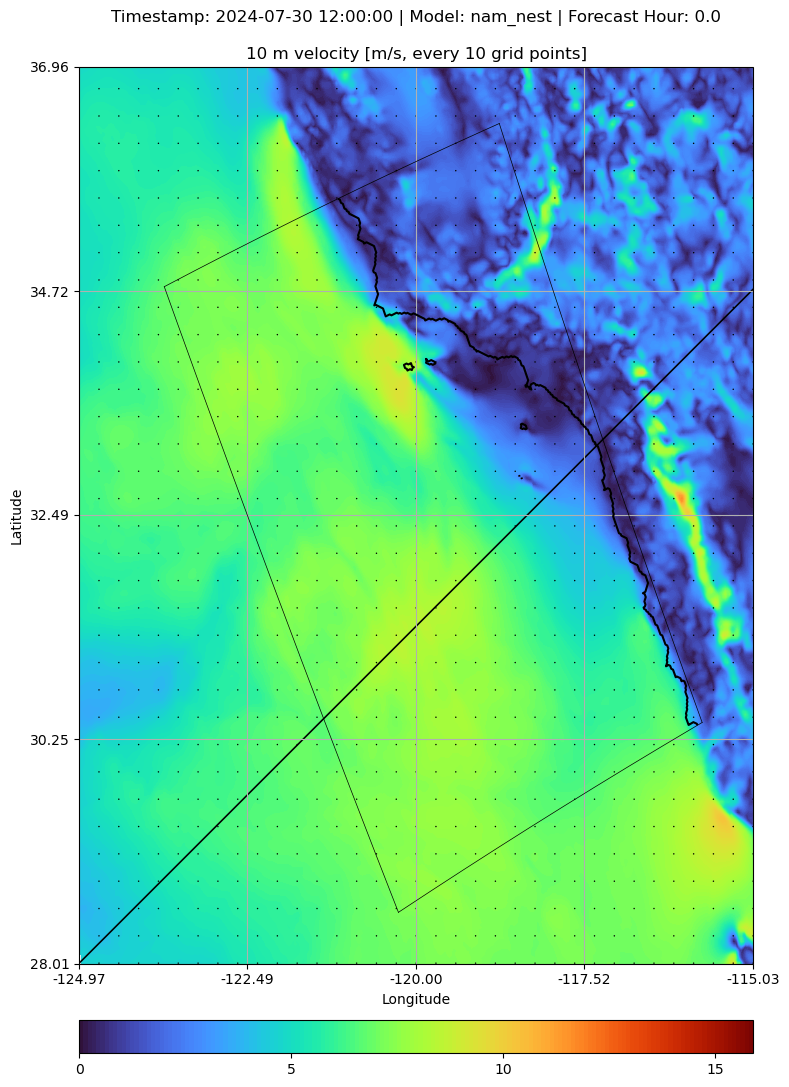

In [36]:
#plotting example for ATM
pltfuns.plot_atm_fields(ATM, RMG, PFM, fields_to_plot= 'velocity', show=True)

In [28]:
ATM_R  = atmfuns.get_atm_data_on_roms_grid(ATM,RMG)

/home/a1jadhav/pfm_root/PFM/driver/../sdpm_py_util/plotting_functions.py:309: RuntimeWarning: overflow encountered in square
  magnitude = np.sqrt(U**2 + V**2)


<Figure size 640x480 with 0 Axes>

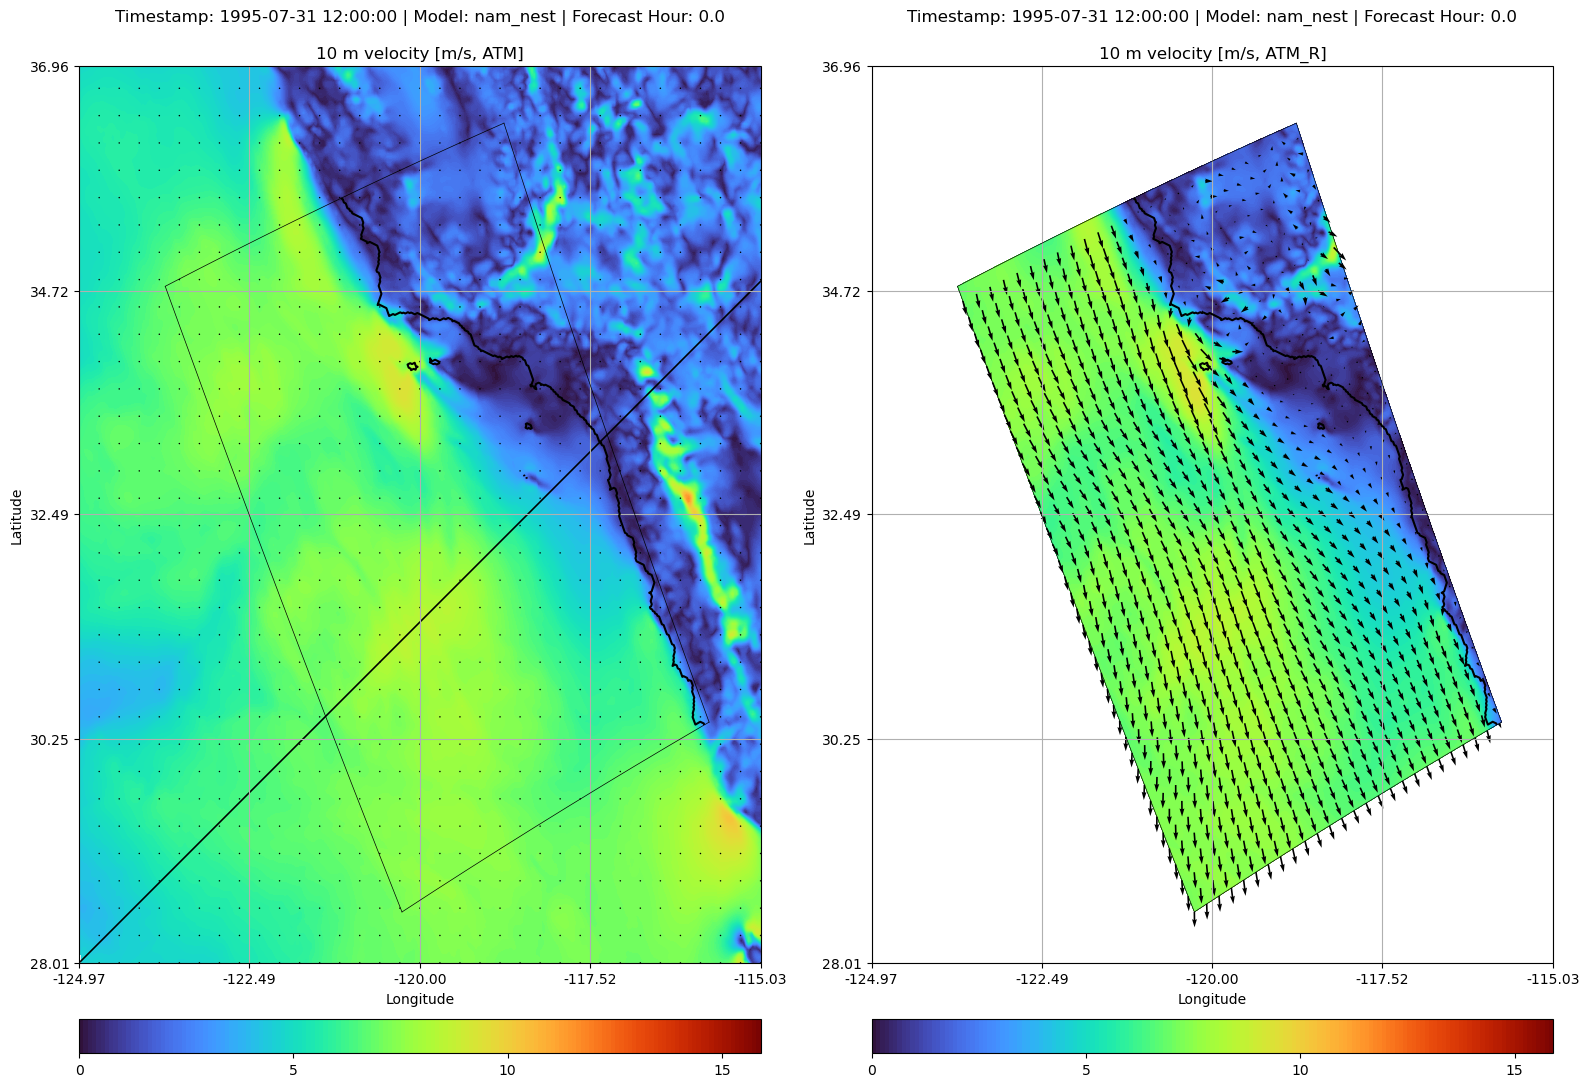

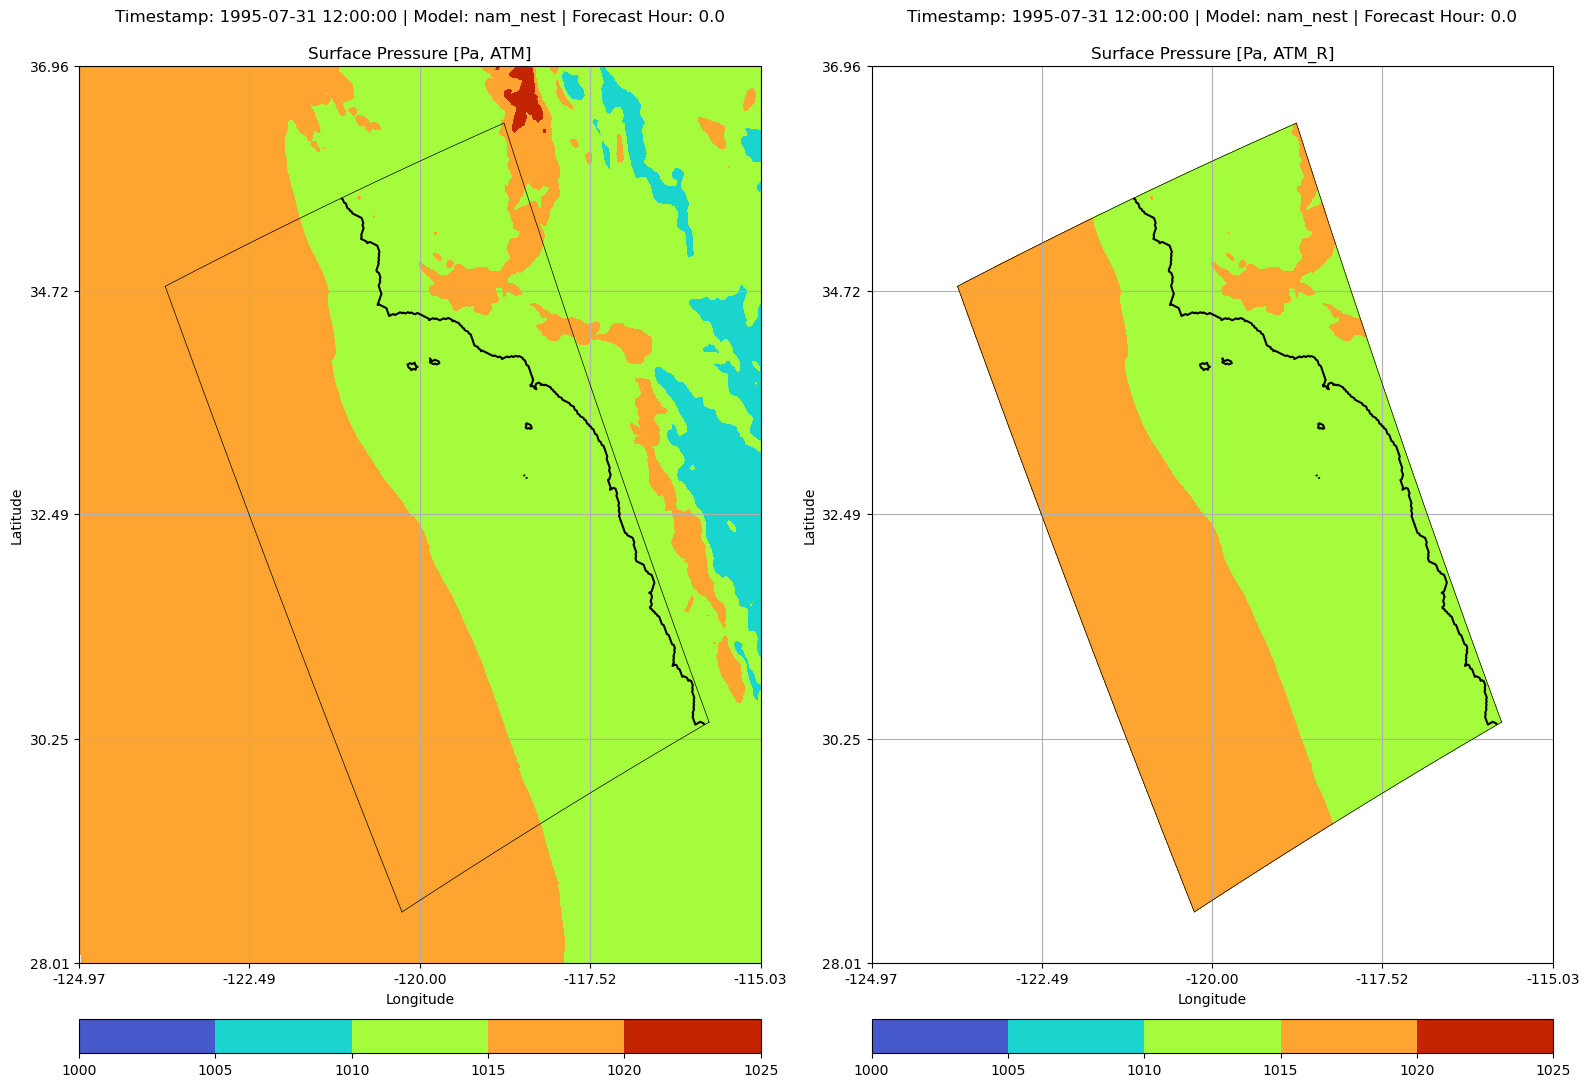

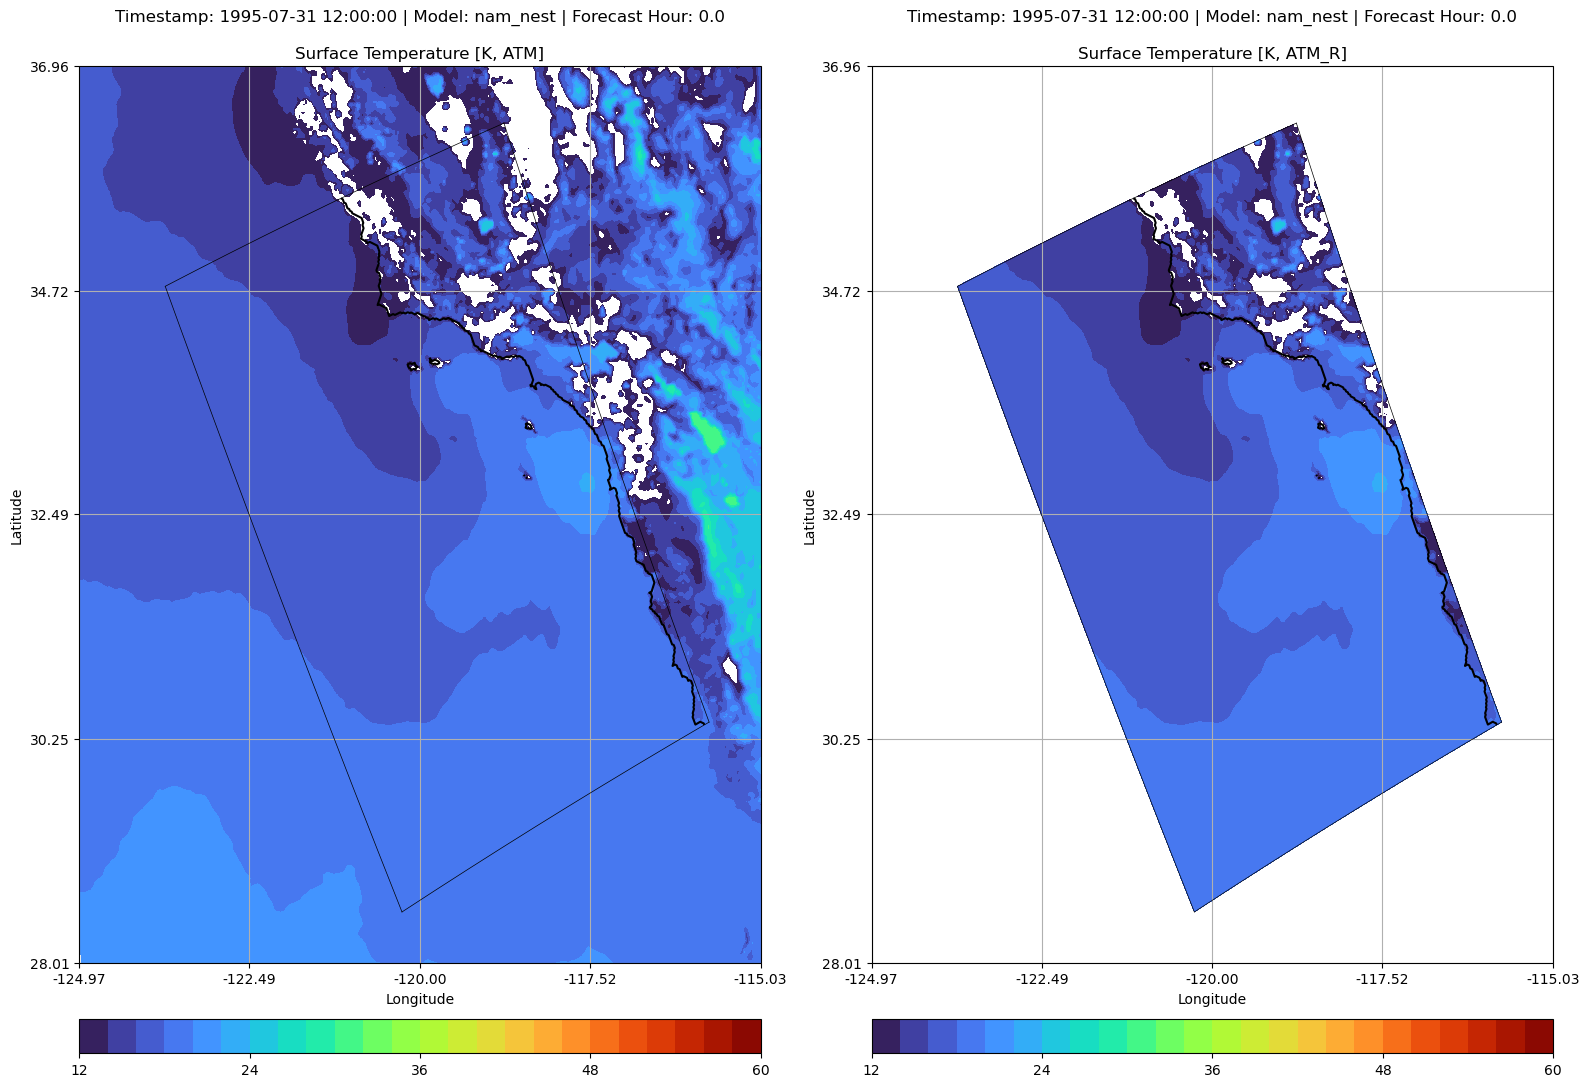

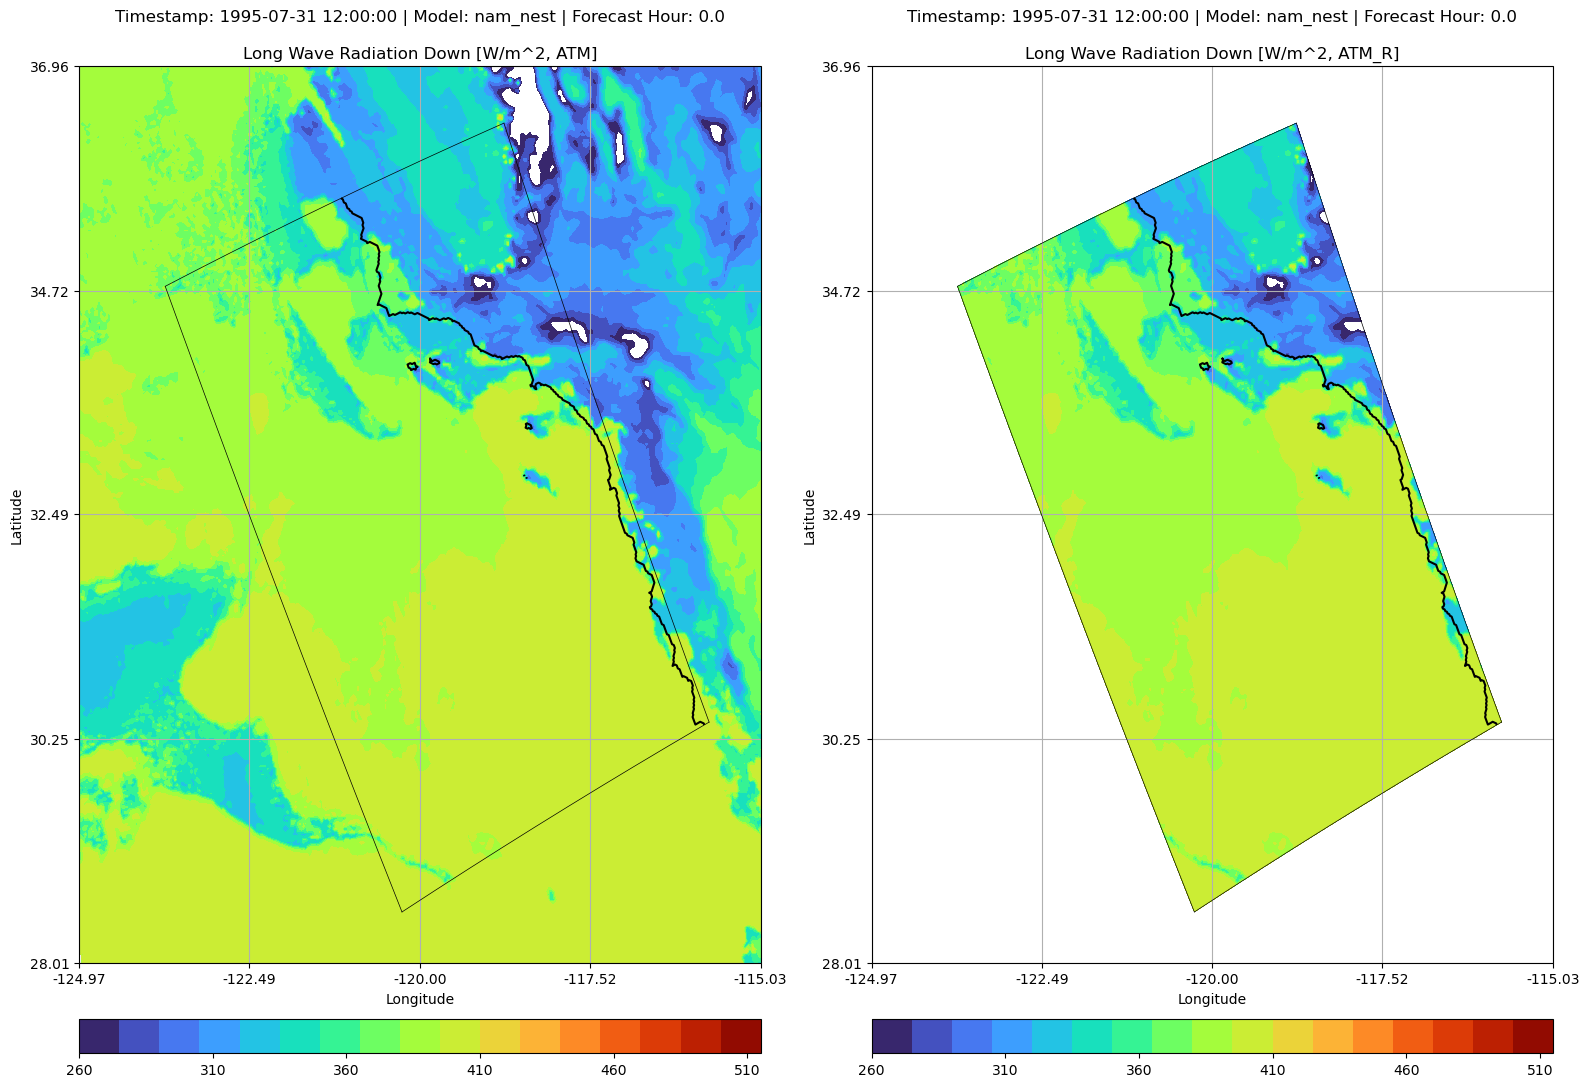

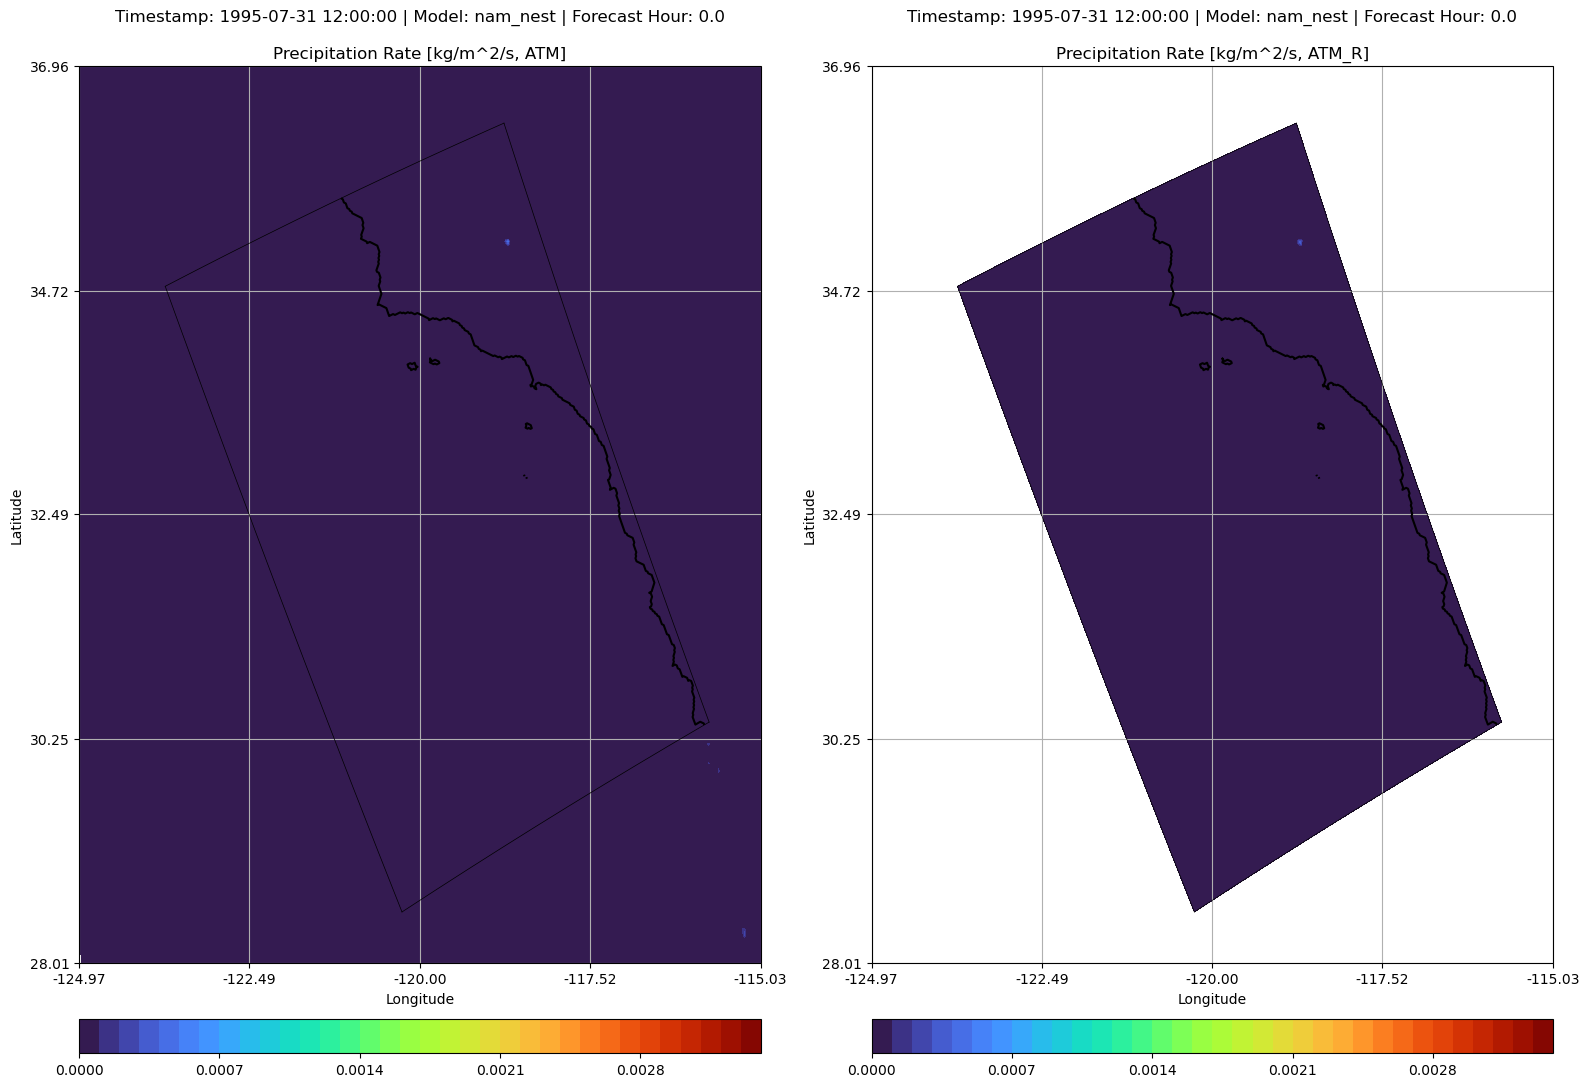

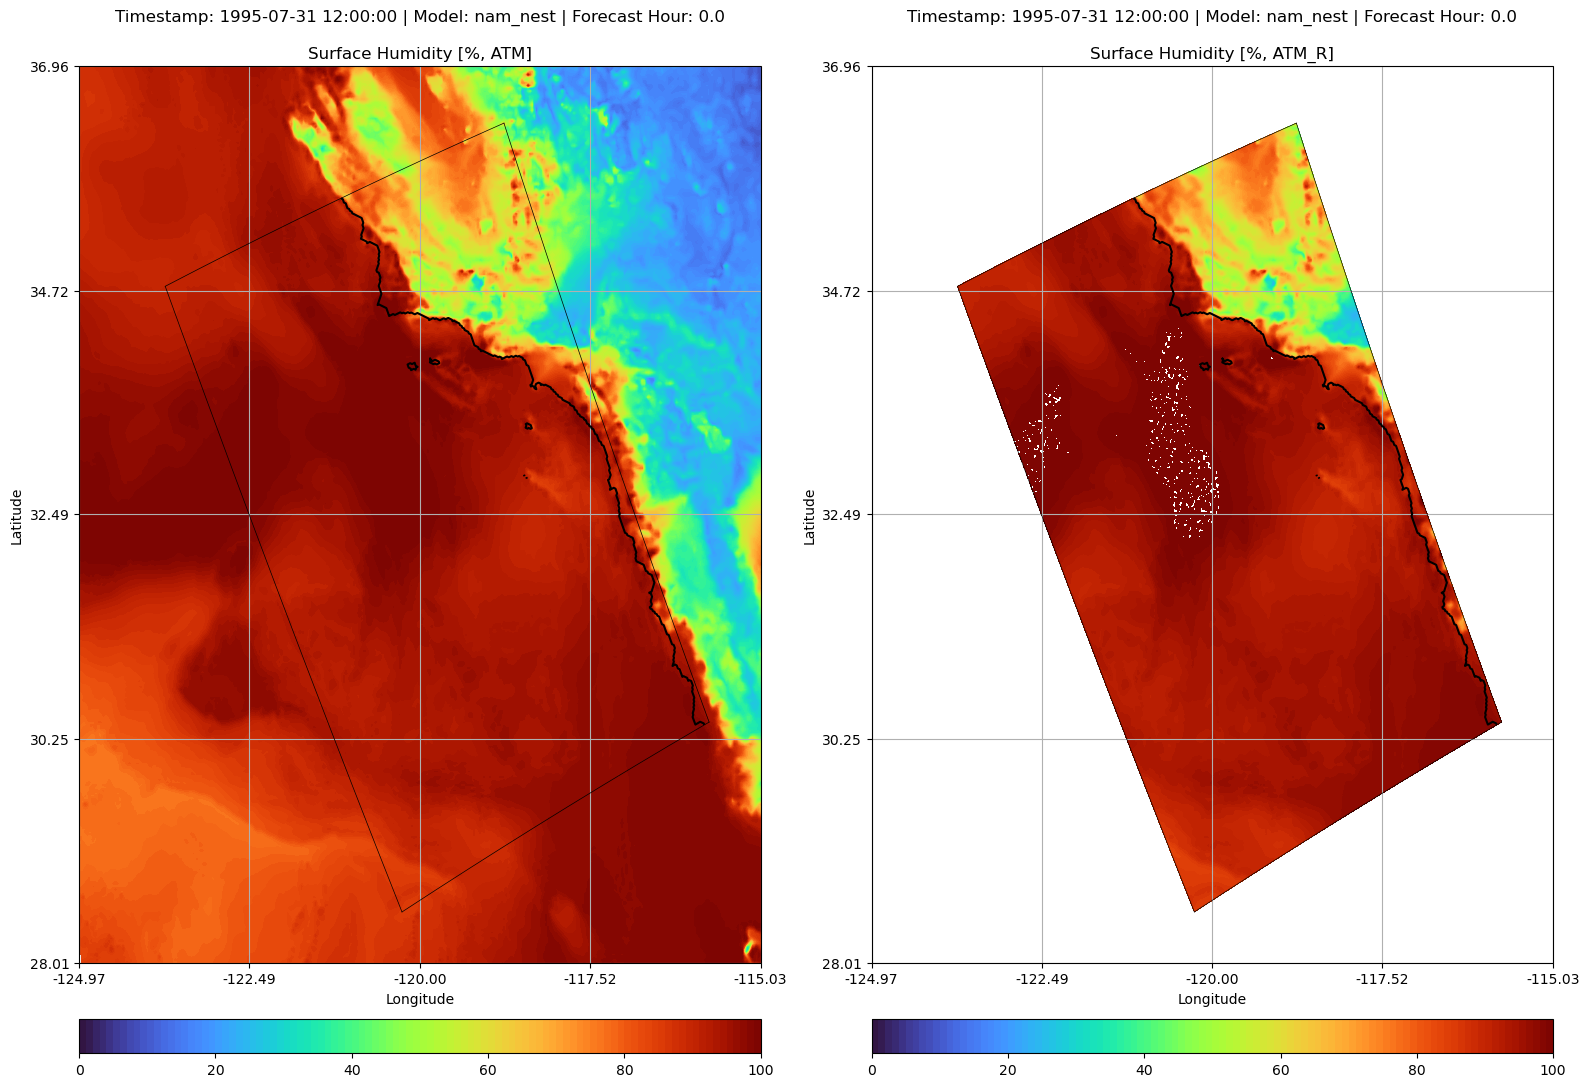

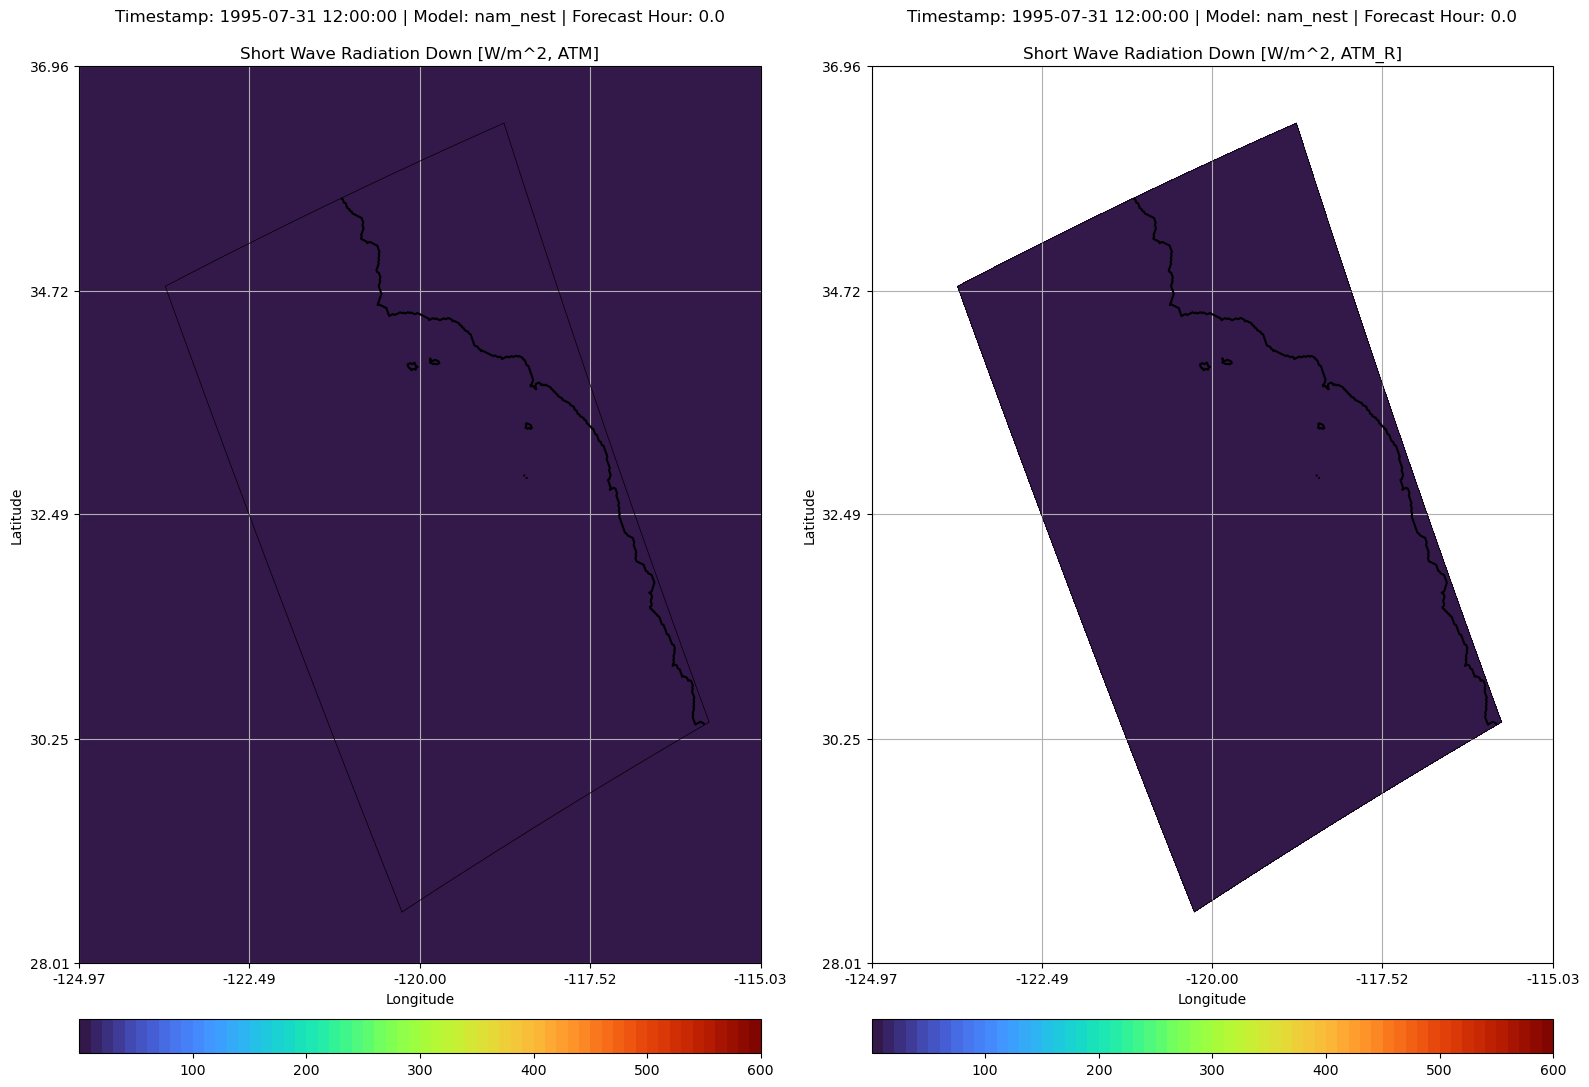

In [37]:
# plotting both ATM and ATM_R
pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM, show = True)

In [38]:
fn_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename
print('driver_run_forcast_LV1: saving ATM file to ' + fn_out)
atmfuns.atm_roms_dict_to_netcdf(ATM_R,fn_out)
print('driver_run_forecast_LV1:  done with writing ATM file, Current time ', datetime.now())
# put in a function to plot the atm.nc file if we want to
pltfuns.load_and_plot_atm(RMG, PFM)
print('done with pltfuns.load_and_plot_atm(PFM)')

driver_run_forcast_LV1: saving ATM file to /scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_ATM_FORCING.nc
<xarray.Dataset>
Dimensions:     (tair_time: 21, er: 390, xr: 253, pair_time: 21, qair_time: 21,
                 wind_time: 21, rain_time: 21, srf_time: 21, lrf_time: 21,
                 time: 21)
Coordinates:
    lat         (er, xr) float64 28.52 28.53 28.54 28.55 ... 36.38 36.39 36.39
    lon         (er, xr) float64 -120.3 -120.2 -120.2 ... -118.8 -118.8 -118.8
    ocean_time  (time) float64 9.342e+03 9.343e+03 ... 9.345e+03 9.345e+03
  * tair_time   (tair_time) float64 9.342e+03 9.343e+03 ... 9.345e+03 9.345e+03
  * pair_time   (pair_time) float64 9.342e+03 9.343e+03 ... 9.345e+03 9.345e+03
  * qair_time   (qair_time) float64 9.342e+03 9.343e+03 ... 9.345e+03 9.345e+03
  * wind_time   (wind_time) float64 9.342e+03 9.343e+03 ... 9.345e+03 9.345e+03
  * rain_time   (rain_time) float64 9.342e+03 9.343e+03 ... 9.345e+03 9.345e+03
  * srf_time    (srf_time) float64 9.342e+03 9.343

In [39]:
print('before getting OCN, using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')

use_ncks = 0 # flag to get data using ncks. if =0, then a pre saved pickle file is loaded.
if use_ncks == 1:
    OCN = ocnfuns.get_ocn_data_as_dict(yyyymmdd,run_type,ocn_mod,'ncks_para',PFM)
    print('driver_run_forecast_LV1: done with get_ocn_data_as_dict: Current time ',datetime.now() )
    print('after getting OCN with ncks_para, using:')
    print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
    print('kilobytes')
else:
    save_ocn = 0 # if 0, this loads the pickle file. if 1, it saves the pickle file
    import pickle
    # save the OCN dict so that we can restart the python session
    # and not have to worry about opendap timing out
    fnout='/scratch/PFM_Simulations/LV1_Forecast/Forc/ocn_dict_file_2024-07-29T12:00.pkl'
    if save_ocn == 1:
        with open(fnout,'wb') as fp:
            pickle.dump(OCN,fp)
            print('OCN dict saved with pickle')
    else:
        with open(fnout,'rb') as fp:
            OCN = pickle.load(fp)
            print('OCN dict loaded with pickle')
            print('after getting OCN from file, using:')
            print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
            print('kilobytes')

before getting OCN, using:
1549596
kilobytes
OCN dict loaded with pickle
after getting OCN from file, using:
1886624
kilobytes


In [42]:
#Cell that plots the OCN data
pltfuns.plot_ocn_fields_from_dict(OCN, RMG, PFM)

In [43]:
print('before gc.collect and getting OCN_R, using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')
gc.collect()
print('after gc.collect and before OCN_R, using:')
print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print('kilobytes')
# put the ocn data on the roms grid
print('starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)')
OCN_R  = ocnfuns.hycom_to_roms_latlon(OCN,RMG)
print('driver_run_forecast_LV1: done with hycom_to_roms_latlon')
# add OCN + OCN_R plotting function here !!!

# del OCN

before gc.collect and getting OCN_R, using:
1903452
kilobytes
after gc.collect and before OCN_R, using:
1903452
kilobytes
starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)
before interp to roms grid, using:
1903452
kilobytes
doing:
zeta
doing:
temp
doing:
salt
doing:
u
doing:
v
before rotating urm, using:
4380332
kilobytes


: 